## Relax Data Science Challenge

In [169]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
import statsmodels.api as sm

In [85]:
#read in datasets
user_engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [86]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users.last_session_creation_time.fillna(1588121471, inplace=True)
users['last_session_creation_time'] = users['last_session_creation_time'].apply(dt.fromtimestamp)
current = users['last_session_creation_time'][7]
users['last_session_creation_time'] = users['last_session_creation_time'].apply(lambda x: 'NaN' if x==current else x)
users.last_session_creation_time.fillna(users.creation_time, inplace=True)
users.invited_by_user_id.fillna(0, inplace=True)

In [220]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
user_engagement.loc[:,'new_time'] = user_engagement['time_stamp'].apply(dt.timestamp)
user_engagement.loc[:,'diffs'] = user_engagement['new_time'].diff()
user_engagement.loc[:,'within_week'] = user_engagement['diffs'].between(86400,604800)
user_engagement.loc[:,'ww1'] = user_engagement['within_week'] + user_engagement['within_week'].shift()
user_engagement.loc[:,'ww2'] = user_engagement['within_week'] + user_engagement['within_week'].shift(periods=-1)
user_engagement.loc[:,'ww3'] = user_engagement['ww1'] + user_engagement['ww2']
user_engagement.loc[:,'ww_final'] = user_engagement['ww3']>2
user_list = user_engagement.groupby(by='user_id').sum().reset_index()
user_list.loc[:,'Adopted'] = user_list['ww_final'].apply(lambda x: 'Adopted' if x>0 else 'Not-Adopted')
user_list = user_list.drop(['visited','new_time','diffs','within_week','ww_final'], axis=1)

In [245]:
final_df = users.merge(user_list, left_on='object_id', right_on='user_id').drop('user_id', axis=1)

Text(0.5, 1.0, 'How Accounts Are Created')

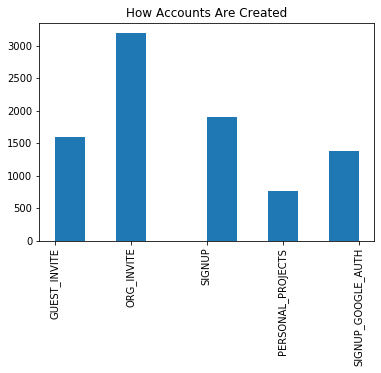

In [247]:
plt.hist(final_df['creation_source'])
plt.xticks(rotation=90)
plt.title('How Accounts Are Created')

In [283]:
final_df[final_df['enabled_for_marketing_drip']==0].count()

object_id                     7482
creation_time                 7482
name                          7482
email                         7482
creation_source               7482
last_session_creation_time    7482
opted_in_to_mailing_list      7482
enabled_for_marketing_drip    7482
org_id                        7482
invited_by_user_id            7482
Adopted                       7482
dtype: int64

Text(0.5, 1.0, 'Do They Receive Marketing Emails')

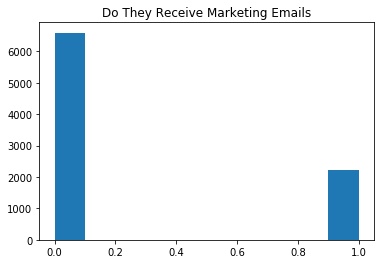

In [256]:
plt.hist(final_df['opted_in_to_mailing_list'])
plt.title('Do They Receive Marketing Emails')

Text(0.5, 1.0, 'Do They Have Marketing Enabled')

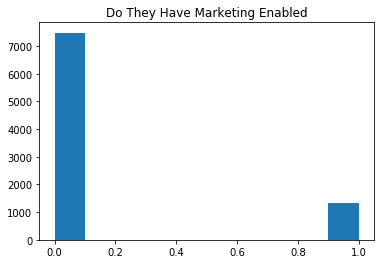

In [257]:
plt.hist(final_df['enabled_for_marketing_drip'])
plt.title('Do They Have Marketing Enabled')

#### Model on appropriate variables

In [258]:
final_to_model = final_df.drop(['object_id','name','email','org_id','invited_by_user_id'], axis=1)

In [259]:
final_to_model.loc[:,'time_since_creation'] = final_to_model['last_session_creation_time']- final_to_model['creation_time']

In [260]:
final_to_model['time_since_creation'] = final_to_model['time_since_creation'].apply(lambda x: x.days)

In [261]:
fm = pd.get_dummies(final_to_model, columns=['creation_source'])

In [262]:
df_X = fm.drop(['Adopted','creation_time','last_session_creation_time'], axis=1)
df_X = df_X.replace(-1,0)
df_y = fm.Adopted
#cat_dtype = pd.api.types.CategoricalDtype(categories=['Not-Adopted','Adopted'], ordered=True)
df_y = df_y.astype('category')
df_y = df_y.cat.codes

In [264]:
train_X, test_X, train_y, test_y = train_test_split(df_X,df_y, random_state=0)

In [265]:
col_names = train_X.columns
for col in col_names:
    col_mean = train_X[col].mean()
    col_std = train_X[col].std()
    train_X.loc[:,col] = train_X[col].apply(lambda x: (x-col_mean)/col_std)
    test_X.loc[:,col] = test_X[col].apply(lambda x: (x-col_mean)/col_std)

C:\Users\sagun\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\sagun\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\sagun\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [266]:
reg = sm.Logit(endog=train_y, exog=train_X)

In [267]:
result = reg.fit()

Optimization terminated successfully.
         Current function value: 0.118063
         Iterations 11


In [275]:
pred = reg.predict(result.params, exog=test_X)

In [270]:
result.summary()

C:\Users\sagun\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\sagun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sagun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sagun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6617
Model:                          Logit   Df Residuals:                     6610
Method:                           MLE   Df Model:                            6
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:                  0.7652
Time:                        22:33:56   Log-Likelihood:                -781.22
converged:                       True   LL-Null:                       -3327.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
opted_in_to_mailing_list              -0.0384      0.083     -0.461      0.645      -0.202       0.125
enabled_for_marketing_drip            -0.0520      0.080     -0.648      0.517      -0.209       0.105
time_since_creation                  -10.1353      0.250    -40.547      0.000     -10.625      -9.645
creation_source_GUEST_INVITE          -0.0810        nan        nan        nan         nan         nan
creation_source_ORG_INVITE            -0.0366        nan        nan        nan         nan         nan
creation_source_PERSONAL_PROJECTS      0.0514        nan        nan        nan         nan         nan
creation_source_SIGNUP                 0.0031        nan        nan        nan         nan         nan
creation_source_SIGNUP_GOOGLE_AUTH     0.0897        nan        nan        nan         nan         nan
======================================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [278]:
best_threshold = 0
best_fbeta = 0
df = pd.DataFrame(pred)
threshold_list = np.arange(0,1.01, 0.01)
for i in threshold_list:
    Y_test_pred = df.applymap(lambda x: 1 if x>i else 0)
    test_fbeta = fbeta_score(Y_test_pred, test_y, beta=1)
    if test_fbeta > best_fbeta:
        best_threshold = i
        best_fbeta = test_fbeta
print('Best Threshold is {0} with and fbeta of {1}'.format(best_threshold, best_fbeta))

Best Threshold is 0.48 with and fbeta of 0.9706301682349586


C:\Users\sagun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
